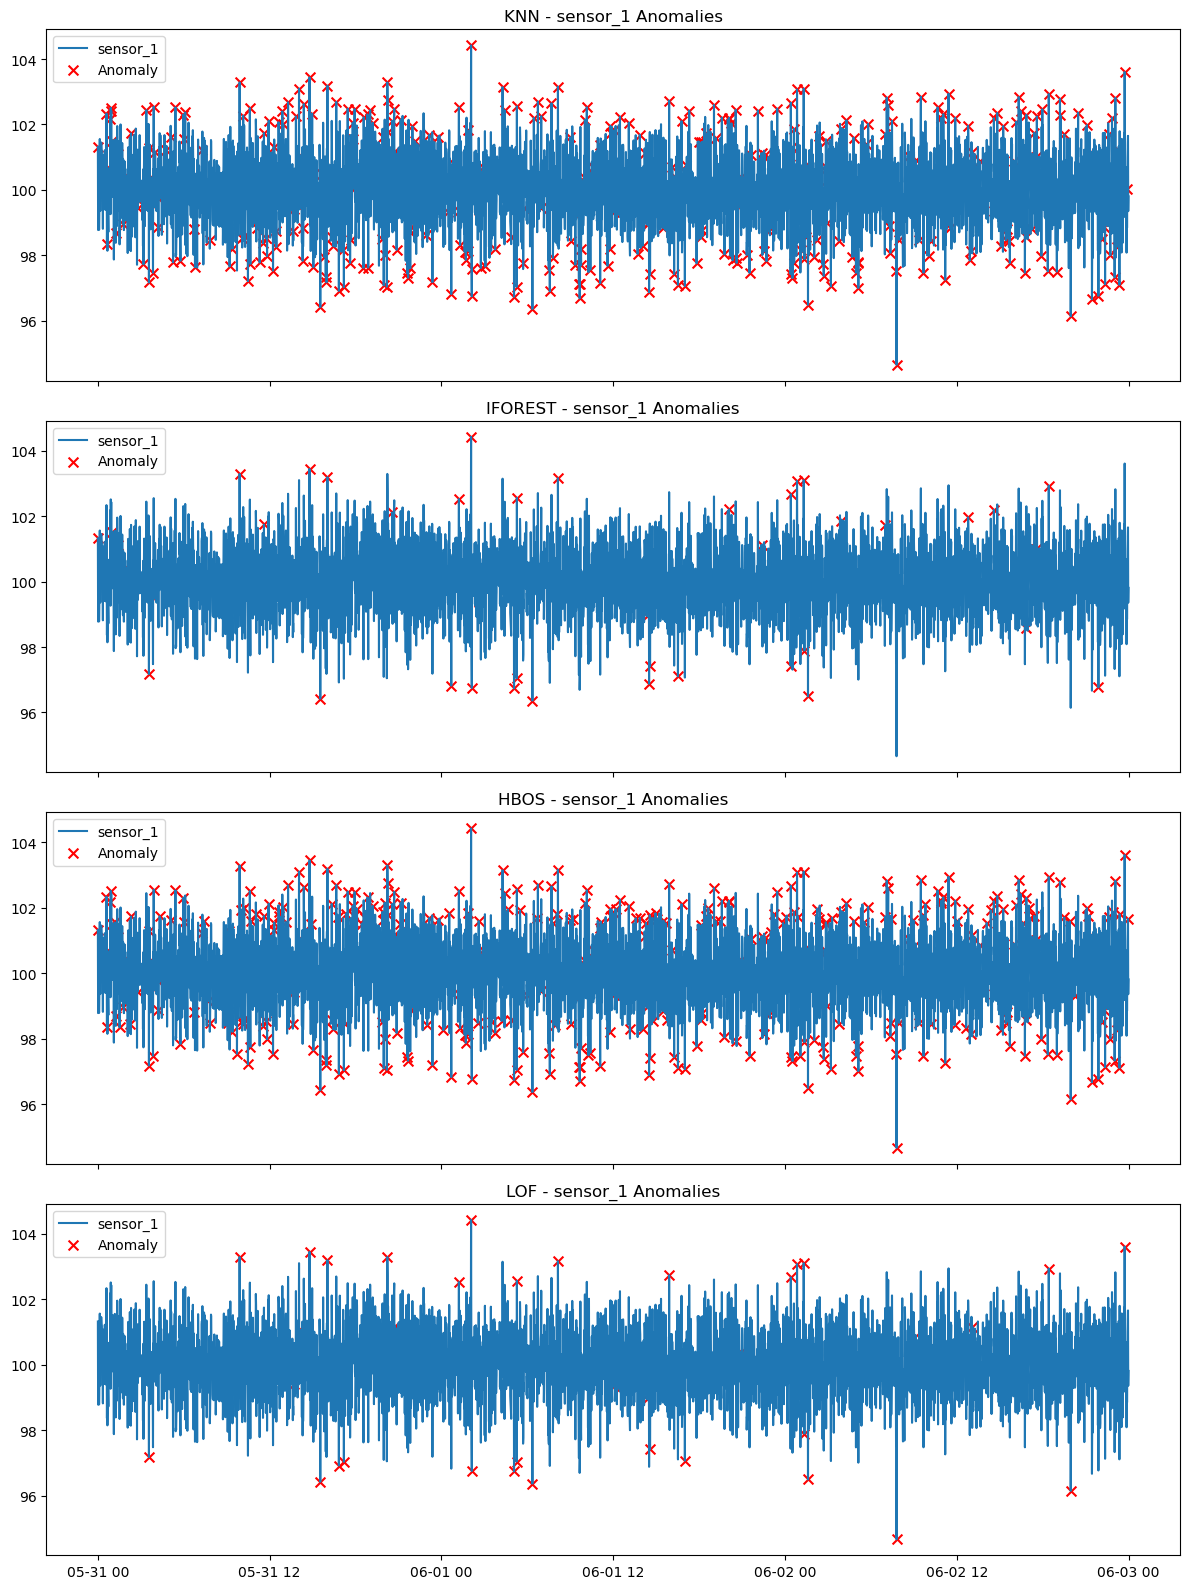

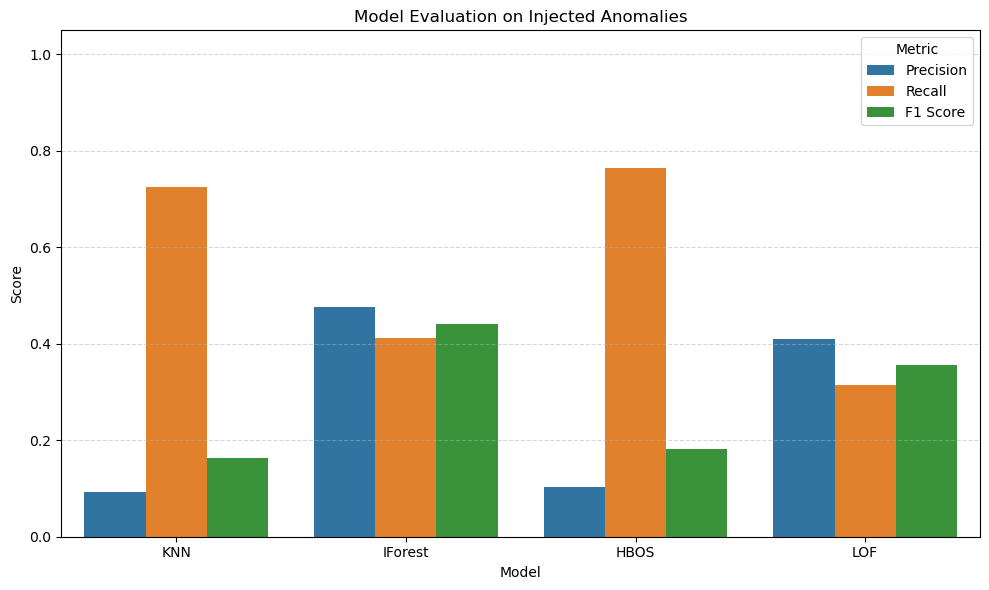

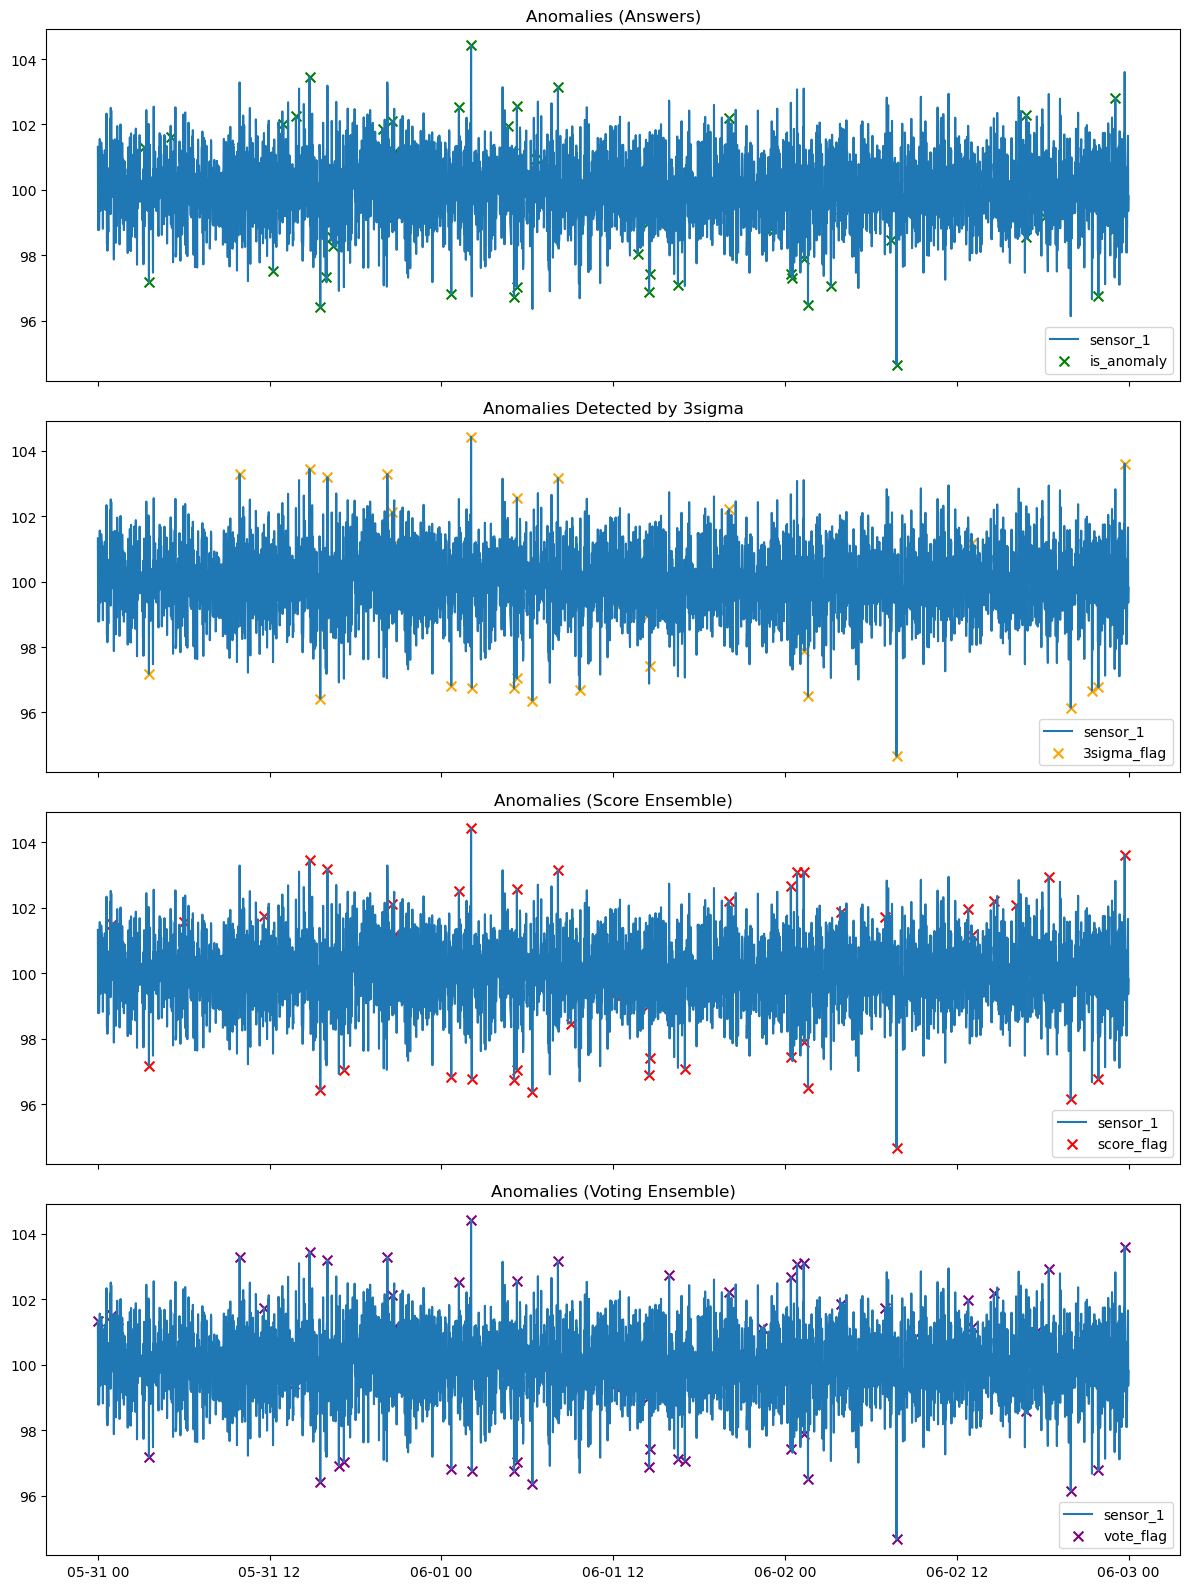

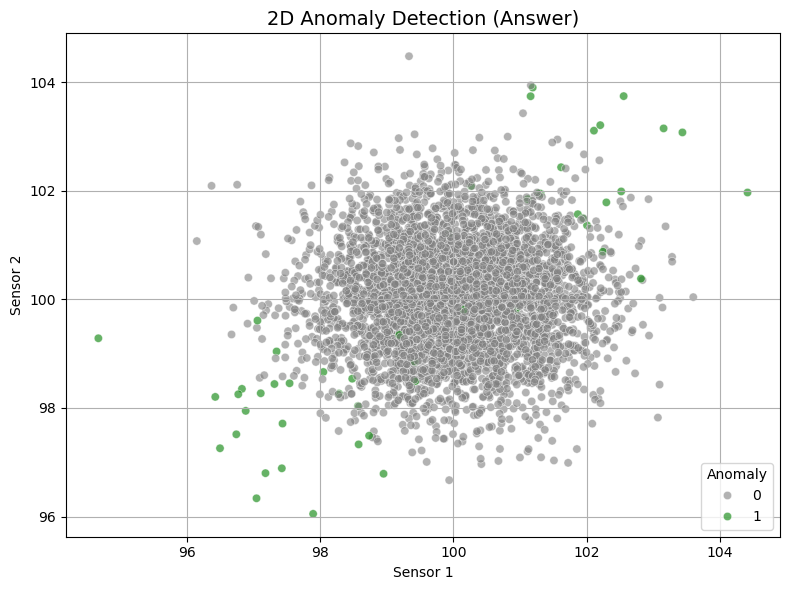

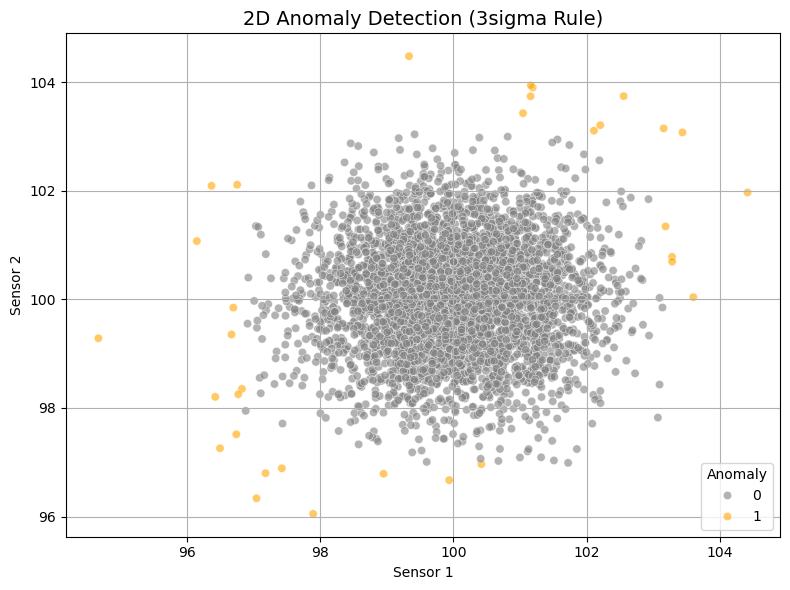

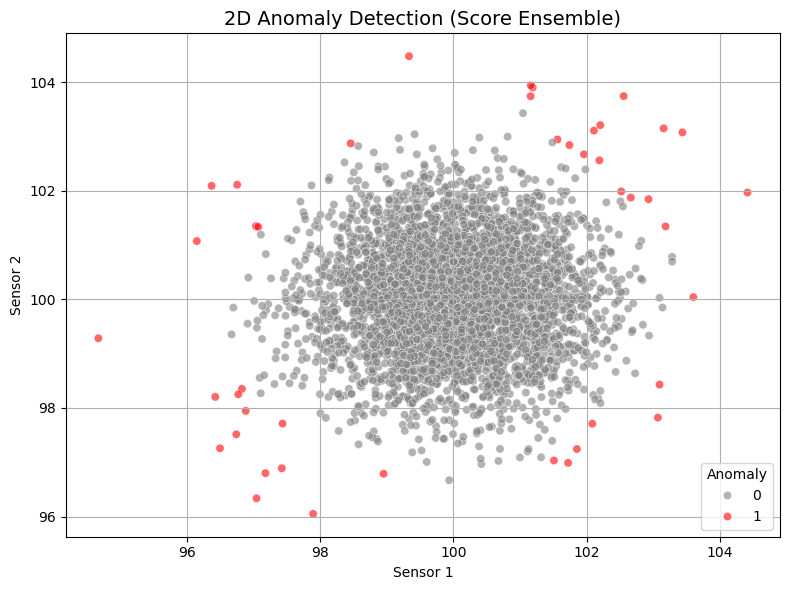

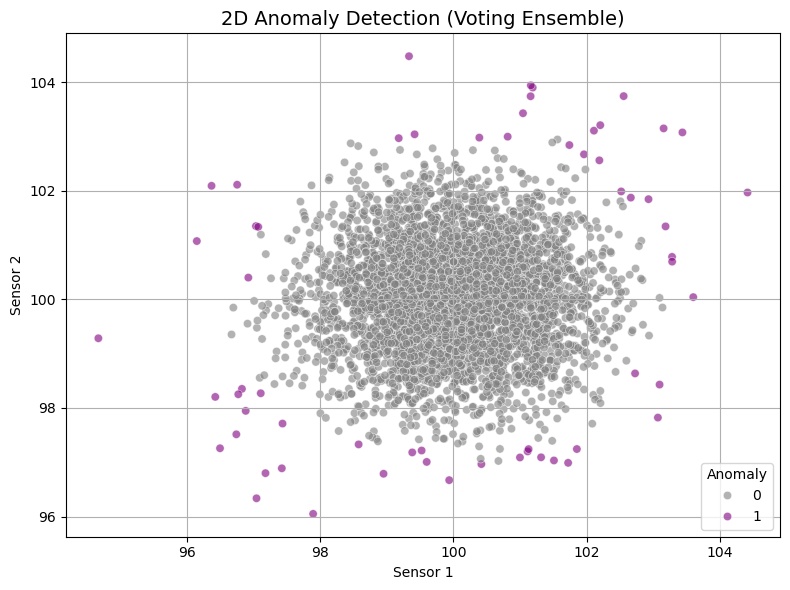

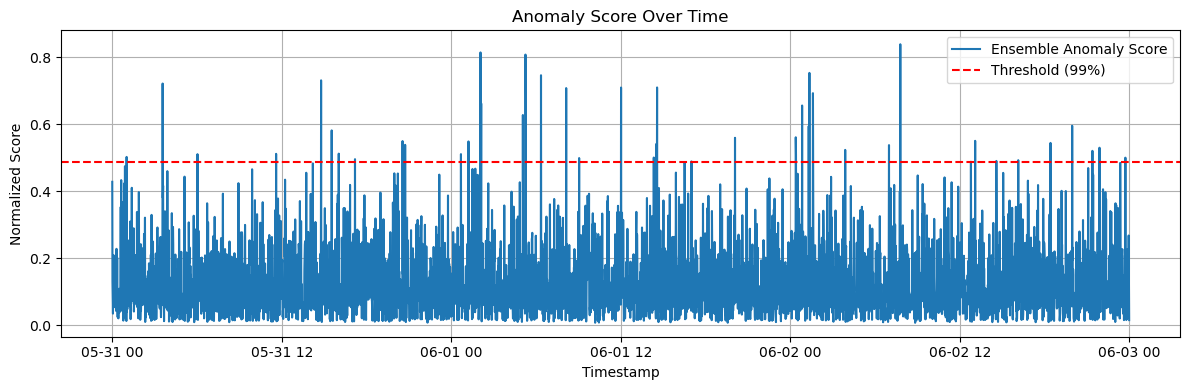

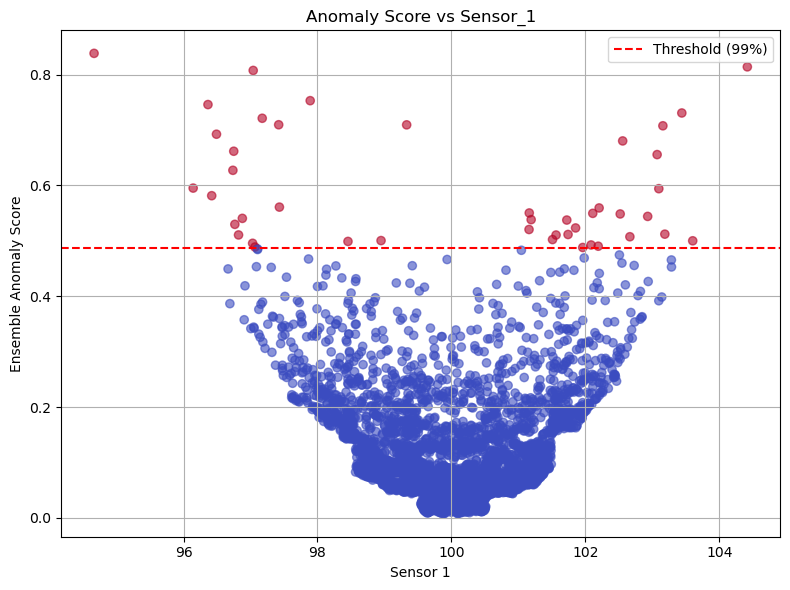

In [8]:
# anomaly_detection_ensemble_pyod.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.hbos import HBOS
from pyod.models.lof import LOF

# --- Configuration ---
np.random.seed(42)
today = pd.Timestamp.today().normalize()
week_ago = today - pd.Timedelta(days=7)
three_days_ago = today - pd.Timedelta(days=3)

# --- Synthetic Data Generation ---
n_samples = 7 * 60 * 24
n_features = 2
n_anomalies = int(0.01 * n_samples)
data = np.random.normal(loc=100, scale=1, size=(n_samples, n_features))
anomaly_indices = np.random.choice(n_samples, size=n_anomalies, replace=False)
for idx in anomaly_indices:
    data[idx] += np.random.choice([1, -1]) * np.random.uniform(2, 2, size=n_features)

# --- DataFrame Conversion ---
time_index = pd.date_range(start=week_ago, periods=n_samples, freq='T')
df = pd.DataFrame(data, columns=['sensor_1', 'sensor_2'])
df['timestamp'] = time_index
df['is_anomaly'] = 0
df.loc[anomaly_indices, 'is_anomaly'] = 1

# --- Filtering Last 3 Days ---
df = df[(df['timestamp'] >= three_days_ago) & (df['timestamp'] <= today)]
df_ans = df.copy()
X = df[['sensor_1', 'sensor_2']].values

# --- PyOD Models with Custom Parameters ---
models = {
    'KNN': KNN(n_neighbors=10, method='largest'),
    'IForest': IForest(n_estimators=100, max_samples='auto', contamination=0.01),
    'HBOS': HBOS(n_bins=10, alpha=0.1),
    'LOF': LOF(n_neighbors=20, contamination=0.01)
}

scores_dict = {}
labels_dict = {}
results_list = []

for name, model in models.items():
    model.fit(X)
    scores = model.decision_function(X)
    labels = model.predict(X)
    scores_dict[name] = MinMaxScaler().fit_transform(scores.reshape(-1, 1)).flatten()
    labels_dict[name] = labels
    results_list.append({
        'Model': name,
        'Precision': precision_score(df_ans['is_anomaly'], labels, zero_division=0),
        'Recall': recall_score(df_ans['is_anomaly'], labels, zero_division=0),
        'F1 Score': f1_score(df_ans['is_anomaly'], labels, zero_division=0)
    })

# --- Visualization per Model ---
fig, axs = plt.subplots(len(models), 1, figsize=(12, 4*len(models)), sharex=True)
for i, model_id in enumerate(models):
    # Use the original dataframe for plotting, overlaying detected anomalies
    axs[i].plot(df['timestamp'], df['sensor_1'], label='sensor_1')
    # Get anomaly indices for this model
    anomaly_idx = np.where(labels_dict[model_id] == 1)[0]
    axs[i].scatter(df['timestamp'].iloc[anomaly_idx],
                   df['sensor_1'].iloc[anomaly_idx],
                   color='red', label='Anomaly', s=50, marker='x')
    axs[i].set_title(f"{model_id.upper()} - sensor_1 Anomalies")
    axs[i].legend()
plt.tight_layout()
plt.show()

# --- Ensemble ---
score_df = pd.DataFrame(scores_dict)
vote_df = pd.DataFrame(labels_dict)
score_df['ensemble_score'] = score_df.mean(axis=1)
threshold = score_df['ensemble_score'].quantile(0.99)
score_df['score_flag'] = (score_df['ensemble_score'] >= threshold).astype(int)
vote_df['vote_flag'] = (vote_df.sum(axis=1) >= vote_df.shape[1]*0.7).astype(int)

# Reset index to align with score_df and vote_df
df_result = df.reset_index(drop=True).copy()
df_result['score_ensemble'] = score_df['ensemble_score']
df_result['score_flag'] = score_df['score_flag']
df_result['vote_flag'] = vote_df['vote_flag']

# Restore original index if needed
df_result.index = df.index

# --- 3sigma ---
mean = df_result[['sensor_1', 'sensor_2']].mean()
std = df_result[['sensor_1', 'sensor_2']].std()
anomaly_mask = (
    (df_result['sensor_1'] < mean['sensor_1'] - 3 * std['sensor_1']) |
    (df_result['sensor_1'] > mean['sensor_1'] + 3 * std['sensor_1']) |
    (df_result['sensor_2'] < mean['sensor_2'] - 3 * std['sensor_2']) |
    (df_result['sensor_2'] > mean['sensor_2'] + 3 * std['sensor_2'])
)
df_result['3sigma_flag'] = anomaly_mask.astype(int)

# --- Evaluation Chart ---
df_scores = pd.DataFrame(results_list)
df_melted = df_scores.melt(id_vars='Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric')
plt.title("Model Evaluation on Injected Anomalies")
plt.ylim(0, 1.05)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# --- Helper Function ---
def plot_single_anomaly_layer(ax, df, title, flag_column, color, label='sensor_1'):
    ax.plot(df['timestamp'], df[label], label=label)
    ax.scatter(df['timestamp'][df[flag_column] == 1],
               df[label][df[flag_column] == 1],
               color=color, label=flag_column, s=50, marker='x')
    ax.set_title(title)
    ax.legend(loc='lower right')

# --- Time Series Plot Function ---
def plot_time_series_anomalies(df_ans, df, df_result):
    fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)
    plot_single_anomaly_layer(axs[0], df_ans, "Anomalies (Answers)", 'is_anomaly', 'green')
    plot_single_anomaly_layer(axs[1], df_result, "Anomalies Detected by 3sigma", '3sigma_flag', 'orange')
    plot_single_anomaly_layer(axs[2], df_result, "Anomalies (Score Ensemble)", 'score_flag', 'red')
    plot_single_anomaly_layer(axs[3], df_result, "Anomalies (Voting Ensemble)", 'vote_flag', 'purple')
    plt.tight_layout()
    plt.show()

# --- Draw Time Series Plots ---
plot_time_series_anomalies(df_ans, df, df_result)

# --- Generalized 2D Scatter Plot Function ---
def plot_anomaly_scatter(data, x_col, y_col, label_col, title, color):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=data, x=x_col, y=y_col,
        hue=label_col, palette={0: 'gray', 1: color}, alpha=0.6
    )
    plt.title(f"2D Anomaly Detection ({title})", fontsize=14)
    plt.xlabel(x_col.replace('_', ' ').title())
    plt.ylabel(y_col.replace('_', ' ').title())
    plt.legend(title="Anomaly", loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Final Visuals ---
plot_anomaly_scatter(df_ans, 'sensor_1', 'sensor_2', 'is_anomaly', 'Answer', 'green')
plot_anomaly_scatter(df_result, 'sensor_1', 'sensor_2', '3sigma_flag', '3sigma Rule', 'orange')
plot_anomaly_scatter(df_result, 'sensor_1', 'sensor_2', 'score_flag', 'Score Ensemble', 'red')
plot_anomaly_scatter(df_result, 'sensor_1', 'sensor_2', 'vote_flag', 'Voting Ensemble', 'purple')

# --- Anomaly Score Over Time ---
plt.figure(figsize=(12, 4))
plt.plot(df_result['timestamp'], df_result['score_ensemble'], label='Ensemble Anomaly Score')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold (99%)')
plt.title('Anomaly Score Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Normalized Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Anomaly Score vs Sensor_1 ---
plt.figure(figsize=(8, 6))
plt.scatter(df_result['sensor_1'], df_result['score_ensemble'], c=df_result['score_flag'], cmap='coolwarm', alpha=0.6)
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold (99%)')
plt.title('Anomaly Score vs Sensor_1')
plt.xlabel('Sensor 1')
plt.ylabel('Ensemble Anomaly Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
